# Coherence Testing From Scratch

In [1]:
from __future__ import print_function
#from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim
import pandas as pd
import numpy as np
import sys
import re
import itertools
import time
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
from nltk.corpus import wordnet

In [2]:
import logging
import numpy as np

logger = logging.getLogger(__name__)

def s_one_pre(topics):
    """
    This function performs s_one_pre segmentation on a list of topics.
    s_one_pre segmentation is defined as: s_one_pre = {(W', W*) | W' = {w_i};
                                                                  W* = {w_j}; w_i, w_j belongs to W; i > j}
    Example:
        >>> topics = [np.array([1, 2, 3]), np.array([4, 5, 6])]
        >>> s_one_pre(topics)
        [[(2, 1), (3, 1), (3, 2)], [(5, 4), (6, 4), (6, 5)]]
    Args:
    ----
    topics : list of topics obtained from an algorithm such as LDA. Is a list such as [array([ 9, 10, 11]), array([ 9, 10,  7]), ...]
    Returns:
    -------
    s_one_pre : list of list of (W', W*) tuples for all unique topic ids
    """
    s_one_pre = []

    for top_words in topics:
        s_one_pre_t = []
        for w_prime_index, w_prime in enumerate(top_words[1:]):
            for w_star in top_words[:w_prime_index + 1]:
                s_one_pre_t.append((w_prime, w_star))
        s_one_pre.append(s_one_pre_t)

    return s_one_pre

def s_one_one(topics):
    """
    This function performs s_one_one segmentation on a list of topics.
    s_one_one segmentation is defined as: s_one_one = {(W', W*) | W' = {w_i};
                                                                  W* = {w_j}; w_i, w_j belongs to W; i != j}
    Example:
        >>> topics = [np.array([1, 2, 3]), np.array([4, 5, 6])]
        >>> s_one_pre(topics)
        [[(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)], [(4, 5), (4, 6), (5, 4), (5, 6), (6, 4), (6, 5)]]
    Args:
    ----
    topics : list of topics obtained from an algorithm such as LDA. Is a list such as [array([ 9, 10, 11]), array([ 9, 10,  7]), ...]
    Returns:
    -------
    s_one_one : list of list of (W', W*) tuples for all unique topic ids
    """
    s_one_one = []

    for top_words in topics:
        s_one_one_t = []
        for w_prime_index, w_prime in enumerate(top_words):
            for w_star_index, w_star in enumerate(top_words):
                if w_prime_index == w_star_index:
                    continue
                else:
                    s_one_one_t.append((w_prime, w_star))
        s_one_one.append(s_one_one_t)

    return s_one_one

def s_one_set(topics):
    """
    This function performs s_one_set segmentation on a list of topics.
    s_one_set segmentation is defined as: s_one_set = {(W', W*) | W' = {w_i}; w_i belongs to W;
                                                                  W* = W}
    Example:
        >>> topics = [np.array([9, 10, 7])
        >>> s_one_set(topics)
        [[(9, array([ 9, 10,  7])),
          (10, array([ 9, 10,  7])),
          (7, array([ 9, 10,  7]))]]
    Args:
    ----
    topics : list of topics obtained from an algorithm such as LDA. Is a list such as [array([ 9, 10, 11]), array([ 9, 10,  7]), ...]
    Returns:
    -------
    s_one_set : list of list of (W', W*) tuples for all unique topic ids.
    """
    s_one_set = []

    for top_words in topics:
        s_one_set_t = []
        for w_prime in top_words:
            s_one_set_t.append((w_prime, top_words))
        s_one_set.append(s_one_set_t)

    return s_one_set

In [3]:
EPSILON = 1e-12 
def log_ratio_measure(segmented_topics, per_topic_postings, num_docs, normalize=False):
    """
    If normalize=False:
        Popularly known as PMI.
        This function calculates the log-ratio-measure which is used by
        coherence measures such as c_v.
        This is defined as: m_lr(S_i) = log[(P(W', W*) + e) / (P(W') * P(W*))]
    If normalize=True:
        This function calculates the normalized-log-ratio-measure, popularly knowns as
        NPMI which is used by coherence measures such as c_v.
        This is defined as: m_nlr(S_i) = m_lr(S_i) / -log[P(W', W*) + e]
    Args:
    ----
    segmented topics : Output from the segmentation module of the segmented topics. Is a list of list of tuples.
    per_topic_postings : Output from the probability_estimation module. Is a dictionary of the posting list of all topics
    num_docs : Total number of documents in corpus. Used for calculating probability.
    Returns:
    -------
    m_lr : List of log ratio measures on each set in segmented topics.
    """
    m_lr = []
    for s_i in segmented_topics:
        for w_prime, w_star in s_i:
            w_prime_docs = per_topic_postings[w_prime]
            w_star_docs = per_topic_postings[w_star]
            co_docs = w_prime_docs.intersection(w_star_docs)
            if normalize:
                # For normalized log ratio measure
                numerator = log_ratio_measure([[(w_prime, w_star)]], per_topic_postings, num_docs)[0]
                co_doc_prob = len(co_docs) / float(num_docs)
                m_lr_i = numerator / (-np.log(co_doc_prob + EPSILON))
            else:
                # For log ratio measure without normalization
                numerator = (len(co_docs) / float(num_docs)) + EPSILON
                denominator = (len(w_prime_docs) / float(num_docs)) * (len(w_star_docs) / float(num_docs))
                m_lr_i = np.log(numerator / denominator)
            m_lr.append(m_lr_i)

    return m_lr

In [4]:
import logging

from gensim import interfaces
from gensim.topic_coherence import (probability_estimation,
                                    direct_confirmation_measure, indirect_confirmation_measure,
                                    aggregation)
from gensim.matutils import argsort
from gensim.utils import is_corpus, FakeDict
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import numpy as np

from collections import namedtuple

logger = logging.getLogger(__name__)

boolean_document_based = ['u_mass']
sliding_window_based = ['c_v', 'c_uci', 'c_npmi']
make_pipeline = namedtuple('Coherence_Measure', 'seg, prob, conf, aggr')

coherence_dict = {
    'u_mass': make_pipeline(s_one_pre,
                            probability_estimation.p_boolean_document,
                            direct_confirmation_measure.log_conditional_probability,
                            aggregation.arithmetic_mean),
    'c_v': make_pipeline(s_one_set,
                         probability_estimation.p_boolean_sliding_window,
                         indirect_confirmation_measure.cosine_similarity,
                         aggregation.arithmetic_mean),
    'c_uci': make_pipeline(s_one_one,
                           probability_estimation.p_boolean_sliding_window,log_ratio_measure,
                           aggregation.arithmetic_mean),
    'c_npmi': make_pipeline(s_one_one,
                            probability_estimation.p_boolean_sliding_window,log_ratio_measure,
                            aggregation.arithmetic_mean),
}

sliding_windows_dict = {
    'c_v': 110,
    'c_uci': 10,
    'c_npmi': 10
}

class CoherenceModel(interfaces.TransformationABC):
    """
    Objects of this class allow for building and maintaining a model for topic
    coherence.
    The main methods are:
    1. constructor, which initializes the four stage pipeline by accepting a coherence measure,
    2. the ``get_coherence()`` method, which returns the topic coherence.
    One way of using this feature is through providing a trained topic model. A dictionary has to be explicitly
    provided if the model does not contain a dictionary already.
    >>> cm = CoherenceModel(model=tm, corpus=corpus, coherence='u_mass')  # tm is the trained topic model
    >>> cm.get_coherence()
    Another way of using this feature is through providing tokenized topics such as:
    >>> topics = [['human', 'computer', 'system', 'interface'],
                  ['graph', 'minors', 'trees', 'eps']]
    >>> cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=dictionary, coherence='u_mass') # note that a dictionary has to be provided.
    >>> cm.get_coherence()
    Model persistency is achieved via its load/save methods.
    """
    def __init__(self, model=None, topics=None, texts=None, corpus=None, dictionary=None, window_size=None, coherence='c_v', topn=10):
        """
        Args:
        ----
        model : Pre-trained topic model. Should be provided if topics is not provided.
        topics : List of tokenized topics. If this is preferred over model, dictionary should be provided.
                 eg. topics = [['human', 'machine', 'computer', 'interface'],
                               ['graph', 'trees', 'binary', 'widths']]
        texts : Tokenized texts. Needed for coherence models that use sliding window based probability estimator.
        corpus : Gensim document corpus.
        dictionary : Gensim dictionary mapping of id word to create corpus. If model.id2word is present, this is not needed.
                     If both are provided, dictionary will be used.
        window_size : Is the size of the window to be used for coherence measures using boolean sliding window as their
                      probability estimator. For 'u_mass' this doesn't matter.
                      If left 'None' the default window sizes are used which are:
                      'c_v' : 110
                      'c_uci' : 10
                      'c_npmi' : 10
        coherence : Coherence measure to be used. Supported values are:
                    'u_mass'
                    'c_v'
                    'c_uci' also popularly known as c_pmi
                    'c_npmi'
                    For 'u_mass' corpus should be provided. If texts is provided, it will be converted to corpus using the dictionary.
                    For 'c_v', 'c_uci' and 'c_npmi' texts should be provided. Corpus is not needed.
        topn : Integer corresponding to the number of top words to be extracted from each topic.
        """
        if model is None and topics is None:
            raise ValueError("One of model or topics has to be provided.")
        elif topics is not None and dictionary is None:
            raise ValueError("dictionary has to be provided if topics are to be used.")
        if texts is None and corpus is None:
            raise ValueError("One of texts or corpus has to be provided.")
        # Check if associated dictionary is provided.
        if dictionary is None:
            if isinstance(model.id2word, FakeDict):
                raise ValueError("The associated dictionary should be provided with the corpus or 'id2word' for topic model"
                                 " should be set as the associated dictionary.")
            else:
                self.dictionary = model.id2word
        else:
            self.dictionary = dictionary
        # Check for correct inputs for u_mass coherence measure.
        if coherence in boolean_document_based:
            if is_corpus(corpus)[0]:
                self.corpus = corpus
            elif texts is not None:
                self.texts = texts
                self.corpus = [self.dictionary.doc2bow(text) for text in self.texts]
            else:
                raise ValueError("Either 'corpus' with 'dictionary' or 'texts' should be provided for %s coherence." % coherence)
        # Check for correct inputs for c_v coherence measure.
        elif coherence in sliding_window_based:
            self.window_size = window_size
            if texts is None:
                raise ValueError("'texts' should be provided for %s coherence." % coherence)
            else:
                self.texts = texts
        else:
            raise ValueError("%s coherence is not currently supported." % coherence)
        self.topn = topn
        self.model = model
        if model is not None:
            self.topics = self._get_topics()
        elif topics is not None:
            self.topics = []
            for topic in topics:
                t_i = []
                for n, _ in enumerate(topic):
                    t_i.append(dictionary.token2id[topic[n]])
                self.topics.append(np.array(t_i))
        self.coherence = coherence

    def __str__(self):
        return coherence_dict[self.coherence].__str__()

    def _get_topics(self):
        """Internal helper function to return topics from a trained topic model."""
        topics = []
        if isinstance(self.model, LdaModel):
            for topic in self.model.state.get_lambda():
                bestn = argsort(topic, topn=self.topn, reverse=True)
                topics.append(bestn)
        elif isinstance(self.model, LdaVowpalWabbit):
            for topic in self.model._get_topics():
                bestn = argsort(topic, topn=self.topn, reverse=True)
                topics.append(bestn)
        elif isinstance(self.model, LdaMallet):
            for topic in self.model.word_topics:
                bestn = argsort(topic, topn=self.topn, reverse=True)
                topics.append(bestn)
        else:
            raise ValueError("This topic model is not currently supported. Supported topic models are"
                             "LdaModel, LdaVowpalWabbit and LdaMallet.")
        return topics

    def get_coherence(self):
        """
        Return coherence value based on pipeline parameters.
        """
        measure = coherence_dict[self.coherence]
        segmented_topics = measure.seg(self.topics)
        if self.coherence in boolean_document_based:
            per_topic_postings, num_docs = measure.prob(self.corpus, segmented_topics)
            confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_docs)
        elif self.coherence in sliding_window_based:
            if self.window_size is not None:
                self.window_size = sliding_windows_dict[self.coherence]
            per_topic_postings, num_windows = measure.prob(texts=self.texts, segmented_topics=segmented_topics,
                                                           dictionary=self.dictionary, window_size=self.window_size)
            if self.coherence == 'c_v':
                confirmed_measures = measure.conf(self.topics, segmented_topics, per_topic_postings, 'nlr', 1, num_windows)
            else:
                if self.coherence == 'c_npmi':
                    normalize = True
                else:
                    # For c_uci
                    normalize = False
                confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_windows, normalize=normalize)
        return measure.aggr(confirmed_measures)

In [42]:
texts = [['human', 'interface', 'computer'],
         ['survey', 'user', 'computer', 'system', 'response', 'time'],
         ['eps', 'user', 'interface', 'system'],
         ['system', 'human', 'system', 'eps'],
         ['user', 'response', 'time'],
         ['trees'],
         ['graph', 'trees'],
         ['graph', 'minors', 'trees'],
         ['graph', 'minors', 'survey']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [43]:
# make LDa model
goodLdaModel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, iterations=50, num_topics=2)
badLdaModel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, iterations=1, num_topics=2)

In [44]:
# U_mass Coherence
good_um = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
bad_um = CoherenceModel(model=badLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')

In [45]:
# C_V Coherence
good_cv = CoherenceModel(model=goodLdaModel, texts=texts, dictionary=dictionary, coherence='c_v')
bad_cv = CoherenceModel(model=badLdaModel, texts=texts, dictionary=dictionary, coherence='c_v')

In [46]:
# C_UCI Coherence
good_uci = CoherenceModel(model=goodLdaModel, texts=texts, dictionary=dictionary, coherence='c_uci')
bad_uci = CoherenceModel(model=badLdaModel, texts=texts, dictionary=dictionary, coherence='c_uci')

In [47]:
# C_NPMI Coherence
good_npmi = CoherenceModel(model=goodLdaModel, texts=texts, dictionary=dictionary, coherence='c_npmi')
bad_npmi = CoherenceModel(model=badLdaModel, texts=texts, dictionary=dictionary, coherence='c_npmi')

In [49]:
print("higher score is better")
print("good model umass: ", good_um.get_coherence())
print("bad model umass: ", bad_um.get_coherence())
print("good model cv: ", good_cv.get_coherence())
print("bad model cv: ", bad_cv.get_coherence())
print("good model cuci: ", good_uci.get_coherence())
print("bad model cuci: ", bad_uci.get_coherence())
print("good model cnpmi: ", good_npmi.get_coherence())
print("bad model cnpmi: ", bad_npmi.get_coherence())

higher score is better
good model umass:  -14.0810486906
bad model umass:  -14.7170181547
good model cv:  0.385963126348
bad model cv:  0.341017550076
good model cuci:  -12.7031159941
bad model cuci:  -13.2760131081
good model cnpmi:  -0.288386836533
bad model cnpmi:  -0.327176330368


# Coherence Testing From Saved Corpus

In [5]:
import pickle
import gensim
import os
import pylab as plt
import numpy as np
import re
import pandas as pd
import seaborn as sb

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [6]:
_MODELS_DIR = "saved_models/"
key="Y02E_10_20"
m1 ="DTM_model"
m2 ="DIM_model"
dict_file = "{}.dict".format(key)
corpus_file = "{}.mm".format(key)

In [7]:
import inspect
inspect.getargspec(CoherenceModel.__init__)

ArgSpec(args=['self', 'model', 'topics', 'texts', 'corpus', 'dictionary', 'window_size', 'coherence', 'topn'], varargs=None, keywords=None, defaults=(None, None, None, None, None, None, 'c_v', 10))

In [8]:
# get corpus
corpus = gensim.corpora.MmCorpus(os.path.join(_MODELS_DIR, corpus_file))

# get dictionary
dictionary = gensim.corpora.Dictionary.load(os.path.join(_MODELS_DIR, dict_file))

# get DTM model
filehandler = open(_MODELS_DIR + m1 + ".obj",'r')
DTM = pickle.load(filehandler)
filehandler.close()

In [9]:
# NEED TO GET TEXTS FROM SAVED CORPUS! 
# but it's serialized so you'll have to undo the serialization

In [ ]:
start = datetime.now()
c_v = []
for n, topic in enumerate(topics):
    print n  # for personal monitoring purposes. sorry for this
    try:
        cm = CoherenceModel(topics=topic, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
    except KeyError:
        pass
end = datetime.now()
print "Time taken: %s" % (end - start)

# Coherence Testing From Abstracts

In [6]:
from DTM_Pipeline import Pipeline

# read in data
# make corpus, texts etc.
pl = Pipeline(key="Y02E_10_20",m_type="DIM",num_topics=10)
pl.make_corpus()

Making dictionary
328.386241198
saving dictionary
0.0477101802826
Saving corpus
153.745569944


In [7]:
def stream_corp(path,approved_ids=None):
    '''generator for iterating through lines of the data
    '''
    # regex for sanitizing the abstracts
    html = re.compile(r'\<[^\>]*\>')
    nonan = re.compile(r'[^a-zA-Z ]')

    # read file one line at a time and sanitize
    for line in pd.read_csv(path,sep=',', chunksize=1):
        if approved_ids == None:
            line = line["appln_abstract"].values[0]
            line = nonan.sub(' ',html.sub('',str(line))).lower().split()
            line = stem_doc(line) #apply lemmatization/stemming
            yield line
        else: # if there are approved_ids
            if line["appln_id"].values[0] in approved_ids:
                line = line["appln_abstract"].values[0]
                line = nonan.sub(' ',html.sub('',str(line))).lower().split()
                line = stem_doc(line) #apply lemmatization/stemming
                yield line

def get_time_seq(data_file, min_slice_size=None):
    df =  pd.read_csv(data_file)
    # Create dummy column
    df["Y"] = pd.DatetimeIndex(df["appln_filing_date"]).to_period("A")
    # group by dummy column
    groups = df.groupby("Y")
    # return sorted df and counts dict
    #df = df.sort_values("appln_filing_date")
    approved_ids = None
    if min_slice_size == None:
        # count members of each group
        counts = np.sort([[key,len(groups.groups[key])] for key in groups.groups.keys()], axis=0)
        time_seq = list(counts[:,1])
    else:
        approved_ids = []
        for group in groups.groups.iteritems():
            if len(group[1]) >= min_slice_size:
                approved_ids.append(df.loc[group[1]]["appln_id"].values[:min_slice_size])
        time_seq = [min_slice_size]*len(approved_ids)
    return time_seq, approved_ids  

def get_wordnet_pos(treebank_tag):
    tag_to_type = {'J': wordnet.ADJ, 'V': wordnet.VERB, 'R': wordnet.ADV}
    return tag_to_type.get(treebank_tag[:1], wordnet.NOUN)

def stem_doc(doc):
    lmtzr = WordNetLemmatizer()
    tags = nltk.pos_tag(doc)
    return [lmtzr.lemmatize(word, get_wordnet_pos(tag[1])) for word, tag in zip(doc, tags)]

def progress(percent):
    '''Just a progress bar to be printed to the screen
    '''
    width = 10
    perc = np.floor(percent*width)
    prog = "="*perc + ">"
    if percent != 1:
        print('\r' + 'Progress: [{}] {}%'.format(prog.ljust(width+1), str(percent*100)),end="")
    else:
        print('\r' + 'Progress: [{}] {}%'.format(prog.ljust(width+1), str(percent*100)),end="")
    sys.stdout.flush()

In [8]:
key="Y02E_10_20"
data_file = '../Data/{}.csv'.format(key)
min_slice_size=200
time_seq, approved_ids = get_time_seq(data_file, min_slice_size)

In [9]:
t0 = time.time()
pl.corpus.get_texts()
print(time.time() - t0)

149.246060133


In [10]:
ivd = {v: k for k, v in pl.corpus.dictionary.token2id.iteritems()}

In [11]:
doc = pl.corpus.docs[102]
text = list(itertools.chain(*[[ivd[word[0]]]*word[1] for word in doc]))
text

[u'force',
 u'force',
 u'type',
 u'type',
 u'provide',
 u'sliding',
 u'sliding',
 u'runner',
 u'runner',
 u'runner',
 u'plate',
 u'plate',
 u'plate',
 u'improve',
 u'improve',
 u'wheel',
 u'wheel',
 u'whereby',
 u'crown',
 u'support',
 u'form',
 u'centrifugal',
 u'centrifugal',
 u'water',
 u'water',
 u'water',
 u'water',
 u'water',
 u'water',
 u'water',
 u'produce',
 u'shield',
 u'shield',
 u'shield',
 u'shield',
 u'equip',
 u'pumping',
 u'pumping',
 u'chamber',
 u'chamber',
 u'francis',
 u'francis',
 u'act',
 u'project',
 u'project',
 u'reduce',
 u'shroud',
 u'revolve',
 u'revolve',
 u'method',
 u'since',
 u'plat',
 u'constitution',
 u'cause',
 u'part',
 u'wherein',
 u'spring',
 u'structure',
 u'leakage',
 u'purpose',
 u'sealed',
 u'efficiency',
 u'efficiency',
 u'leak',
 u'leak',
 u'leak',
 u'leak',
 u'outward',
 u'outward',
 u'radially']

In [12]:
texts = []
for doc in pl.corpus.docs:#[:400]: 
    text = list(itertools.chain(*[[ivd[word[0]]]*word[1] for word in doc]))
    texts.append(text)
len(texts)

6400

In [13]:
c_dictionary = Dictionary(texts)
c_corpus = [c_dictionary.doc2bow(text) for text in texts]
c_ts = [200]*32

In [101]:
# create training/validation/testing splits.
#train = pl.corpus.docs[:400]  # [:4800]
#val = pl.corpus.docs[400:600] # [4800:6000]
#test = pl.corpus.docs[600:800] # [6000:]

#train_ts = [200,200]
#val_ts = [200]
#test_ts = [200]

#train_texts = texts[:400]
#val_texts = texts[400:600]
#test_texts = texts[600:800]

In [86]:
#stoplist = set(nltk.corpus.stopwords.words("english"))
#train_dict = make_dict(train, stoplist=stoplist)
#val_dict = make_dict(val, stoplist=stoplist)
#test_dict = make_dict(test, stoplist=stoplist)

In [54]:
nt = 13
# Static LDA
#lda = gensim.models.LdaModel(train, id2word=pl.corpus.dictionary, num_topics=nt)
lda = gensim.models.LdaModel(corpus=c_corpus, id2word=c_dictionary, iterations=40, num_topics=13)

# get and strip down the topics
lda_tops = lda.print_topics(num_topics=nt, num_words=10)
lda_tops = [" ".join(re.findall("[a-zA-Z]+", lda_tops[i][1])).split() for i in range(len(lda_tops))]

In [14]:
import os
dtm_home = os.environ.get('DTM_HOME', "dtm-master")
dtm_path = os.path.join(dtm_home, 'bin', 'dtm-darwin64') if dtm_home else None

In [44]:
# DTM
#dtm = DtmModel(dtm_path,train,train_ts,num_topics=nt,id2word=pl.corpus.dictionary,initialize_lda=True)
dtm = DtmModel(dtm_path,c_corpus,c_ts,num_topics=17,
               id2word=c_dictionary,initialize_lda=True,
               lda_sequence_max_iter=36,
               lda_max_em_iter=15)

# get dtm topics
#dtm_tops = dtm.show_topics(topics=nt,times=1, topn=10)
#dtm_tops = [" ".join(re.findall("[a-zA-Z]+", dtm_tops[i])).split() for i in range(len(dtm_tops))]

In [56]:
dtm_tops = dtm.show_topics(topics=17,times=32, topn=10)
dtm_tops = [" ".join(re.findall("[a-zA-Z]+", dtm_tops[i])).split() for i in range(len(dtm_tops))]

dtm_chron = [test_coherence(dtm_tops[i-5:i],c_corpus,texts,c_dictionary) for i in np.arange(5,32*5,5)]

In [55]:
print(dtm_tops[0:5][0])
print(dtm_tops[5:10][0])
print(dtm_tops[10:15][0])
print(dtm_tops[20:25][0])

[u'end', u'pipe', u'connect', u'support', u'side', u'plate', u'fix', u'section', u'frame', u'b']
[u'liquid', u'tank', u'cylinder', u'buoyancy', u'float', u'pressure', u'piston', u'gas', u'vessel', u'weight']
[u'pressure', u'stage', u'control', u'detect', u'high', u'flow', u'value', u'low', u'hydraulic', u'amount']
[u'water', u'turbine', u'wheel', u'flow', u'generator', u'hydraulic', u'impeller', u'rotate', u'provide', u'passage']


In [93]:
from datetime import date

start = date(1985,1,15)
end = date(2016,9,20)
# 'M' is month-end, instead I need same-day-of-month
dtm_chron.index = [i.year for i in pd.date_range(start, end, freq='A')]
dtm_chron["LDA_Umass"] = [-1.6283]*31
dtm_chron["LDA_UCI"] = [.1904]*31
dtm_chron["LDA_CV"] = [.5021]*31
dtm_chron["LDA_NPMI"] = [.0750]*31

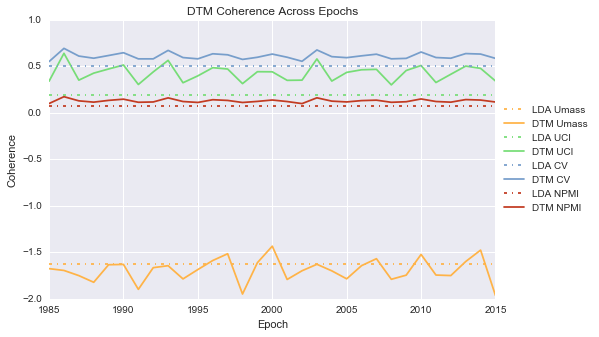

In [120]:
#dtm_chron = pd.DataFrame(dtm_chron)
#dtm_chron.columns = ["u_mass","c_v","c_uci","c_npmi"]
#fig, ax = plt.subplots()
%matplotlib inline
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(dtm_chron["LDA_Umass"], linestyle="-.",color='#FFB347', label="LDA Umass")
ax.plot(dtm_chron["u_mass"], linestyle="-",color='#FFB347', label="DTM Umass")

ax.plot(dtm_chron["LDA_UCI"], linestyle="-.",color='#77dd77', label="LDA UCI")
ax.plot(dtm_chron["c_uci"], linestyle="-",color='#77dd77', label="DTM UCI")

ax.plot(dtm_chron["LDA_CV"], linestyle="-.",color='#779ECB', label="LDA CV")
ax.plot(dtm_chron["c_v"], linestyle="-",color='#779ECB', label="DTM CV")

ax.plot(dtm_chron["LDA_NPMI"], linestyle="-.",color='#C23B22', label="LDA NPMI")
ax.plot(dtm_chron["c_npmi"], linestyle="-",color='#C23B22', label="DTM NPMI")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("Epoch")
ax.set_ylabel("Coherence")
ax.set_title("DTM Coherence Across Epochs")
plt.show()

In [15]:
# DIM
dim = DtmModel(dtm_path,c_corpus,c_ts,num_topics=5,model="fixed",id2word=c_dictionary,initialize_lda=True,
              lda_sequence_max_iter=32,
              lda_max_em_iter=15)

NameError: name 'nt' is not defined

In [36]:
# get dim topics
dim_tops = dim.show_topics(topics=5, times=32, topn=30)
dim_tops = [" ".join(re.findall("[a-zA-Z]+", dim_tops[i])).split() for i in range(len(dim_tops))]

In [38]:
dim_chron = [test_coherence(dim_tops[i-5:i],c_corpus,texts,c_dictionary) for i in np.arange(5,32*5,5)]

In [42]:
#dim_chron = pd.DataFrame(dim_chron)
#dim_chron.columns = ["u_mass","c_v","c_uci","c_npmi"]
#dim_chron.plot()
#plt.show()

In [18]:
# test coherence
def test_coherence(topics,corpus,texts,dictionary):
    coherences = ["u_mass","c_v","c_uci","c_npmi"]
    coh = []
    for c in coherences:
        if c == "u_mass":
            temp = CoherenceModel(topics=topics,corpus=corpus, dictionary=dictionary, coherence=c)
        else:
            temp = CoherenceModel(topics=topics,texts=texts, dictionary=dictionary, coherence=c)
        coh.append(temp.get_coherence())
    return coh

In [21]:
#lda coherence
#lda_coherences = test_coherence(lda_tops,c_corpus,texts,c_dictionary)
#dtm_coherences = test_coherence(dtm_tops,c_corpus,texts,c_dictionary)
#dim_coherences = test_coherence(dim_tops,c_corpus,texts,c_dictionary)
% matplotlib inline

In [20]:
dim_coherences

[-1.3478339230959622,
 0.55808548546310133,
 0.28646467474227749,
 0.10109121507255747]

In [26]:
coherences = pd.DataFrame([lda_coherences,dtm_coherences,dim_coherences])
coherences.columns = ["u_mass","c_v","c_uci","c_npmi"]
coherences["model"] = ["LDA","DTM","DIM"]
coherences

,u_mass,c_v,c_uci,c_npmi,model
0,-0.944523,0.436328,0.078791,0.051414,LDA
1,-1.218611,0.482482,0.150337,0.070074,DTM
2,-1.165670,0.445464,0.107539,0.052452,DIM


In [147]:
# get corpus
#corpus = gensim.corpora.MmCorpus(os.path.join(_MODELS_DIR, corpus_file))
#list(corpus)

In [148]:
#texts = []
#for doc in corpus: 
#    text = list(itertools.chain(*[[ivd[word[0]]]*int(word[1]) for word in doc]))
#    texts.append(text)
#len(texts)

### Parameter tuning LDA


In [14]:
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [45]:
def score(params):
    print("Training with params : ")
    print(params)
    nt = int(params["num_topics"])
    iterations = int(params["iterations"])
    
    # for LDA
    #lda = gensim.models.LdaModel(num_topics=nt,iterations=iterations,corpus=c_corpus, id2word=c_dictionary)
    #lda_tops = lda.print_topics(num_topics=nt, num_words=10)
    #tops = [" ".join(re.findall("[a-zA-Z]+", lda_tops[i][1])).split() for i in range(len(lda_tops))]
    
    # for DTM
    dtm = DtmModel(dtm_path,c_corpus,c_ts,
                   num_topics=nt,id2word=c_dictionary,
                   initialize_lda=True,
                   lda_sequence_max_iter=iterations,
                   lda_max_em_iter=15)
    dtm_tops = dtm.show_topics(topics=nt,times=1, topn=10)
    tops = [" ".join(re.findall("[a-zA-Z]+", dtm_tops[i])).split() for i in range(len(dtm_tops))]
    
    # for DIM
    #dim = DtmModel(dtm_path,c_corpus,c_ts,
    #               num_topics=nt,id2word=c_dictionary,
    #               initialize_lda=True,model="fixed",
    #               lda_sequence_max_iter=iterations,
    #               lda_max_em_iter=15)
    #dim_tops = dim.show_topics(topics=nt,times=1, topn=10)
    #tops = [" ".join(re.findall("[a-zA-Z]+", dim_tops[i])).split() for i in range(len(dim_tops))]
    
    #temp = CoherenceModel(topics=tops,corpus=c_corpus, dictionary=c_dictionary, coherence="u_mass")
    temp = CoherenceModel(topics=tops,texts=texts,dictionary=c_dictionary,coherence="c_uci")
    score = temp.get_coherence()
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

In [46]:
def optimize(trials):
    space = {
             'iterations' : hp.quniform('iterations', 1, 50, 4),
             'num_topics': hp.quniform('num_topics',5,20,1)
             }
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=50)
    print(best)

In [47]:
#Trials object where the history of search will be stored
trials = Trials()

optimize(trials)

Training with params : 
{'num_topics': 14.0, 'iterations': 44.0}
	Score -0.0242376230442


Training with params : 
{'num_topics': 13.0, 'iterations': 40.0}
	Score -0.191210869061


Training with params : 
{'num_topics': 6.0, 'iterations': 32.0}
	Score 0.19380032532


Training with params : 
{'num_topics': 19.0, 'iterations': 24.0}
	Score -0.202279383031


Training with params : 
{'num_topics': 18.0, 'iterations': 24.0}
	Score -0.403685772864


Training with params : 
{'num_topics': 6.0, 'iterations': 12.0}
	Score 0.0386369422234


Training with params : 
{'num_topics': 19.0, 'iterations': 44.0}
	Score 7.77500105691e-05


Training with params : 
{'num_topics': 5.0, 'iterations': 40.0}
	Score 0.317619747411


Training with params : 
{'num_topics': 20.0, 'iterations': 8.0}
	Score -0.0959154646773


Training with params : 
{'num_topics': 6.0, 'iterations': 20.0}
	Score 0.151568192728


Training with params : 
{'num_topics': 16.0, 'iterations': 16.0}
	Score -0.496507597971


Training with p

In [48]:
c_results = []
for t in trials._trials:
    params = list(itertools.chain(*t["misc"]["vals"].values()))
    params.append(t["result"]["loss"])
    c_results.append(params)
c_results = np.array(c_results)

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import pylab as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d',axisbg='white')
ax.scatter(c_results[:,0],c_results[:,1],c_results[:,2],c='b')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_title("c_uci coherence vs. DTM model parameters")
ax.set_xlabel("num_topics")
ax.set_ylabel("iterations")
ax.set_zlabel("c_uci coherence")
plt.show()


In [120]:
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(c_results[:,0],c_results[:,1],c=c_results[:,2], cmap="bwr")

ax.set_xlabel("num_topics")
ax.set_ylabel("iterations")
plt.show()

In [38]:
import copy
#lda_cv_results = copy.deepcopy(c_results)
#lda_umass_results = copy.deepcopy(c_results)
lda_uci_results = copy.deepcopy(c_results)

#dtm_cv_results = copy.deepcopy(c_results)
#dtm_uci_results = copy.deepcopy(c_results)
#dtm_npmi_results = copy.deepcopy(c_results)

#dim_cv_results = copy.deepcopy(c_results)
#dim_umass_results = copy.deepcopy(c_results)
#dim_uci_results = copy.deepcopy(c_results)
#dim_npmi_results = copy.deepcopy(c_results)

#c_results = dtm_uci_results
m_idx = np.argmax(lda_uci_results[:,2])
print("[LDA] best uci coherence:", lda_uci_results[m_idx])

[LDA] best c_v coherence: [ 13.          40.           0.48714611]


In [ ]:
# --- LDA results ---------
m_idx = np.argmax(cv_results[:,2])
print("[LDA] best c_v coherence:", cv_results[m_idx])

m_idx = np.argmax(uci_results[:,2])
print("[LDA] best uci coherence:", uci_results[m_idx])

m_idx = np.argmax(npmi_results[:,2])
print("[LDA] best npmi coherence:", npmi_results[m_idx])

# --- DTM results ---------
m_idx = np.argmax(dtm_umass_results[:,2])
print("[DTM] best umass coherence:", dtm_umass_results[m_idx])

m_idx = np.argmax(dtm_cv_results[:,2])
print("[DTM] best c_v coherence:", dtm_cv_results[m_idx])

m_idx = np.argmax(dtm_uci_results[:,2])
print("[DTM] best uci coherence:", dtm_uci_results[m_idx])

m_idx = np.argmax(dtm_npmi_results[:,2])
print("[DTM] best npmi coherence:", dtm_npmi_results[m_idx])

# --- DIM results ---------
m_idx = np.argmax(dim_umass_results[:,2])
print("[DIM] best umass coherence:", dim_umass_results[m_idx])

m_idx = np.argmax(dim_cv_results[:,2])
print("[DIM] best c_v coherence:", dim_cv_results[m_idx])

m_idx = np.argmax(dim_uci_results[:,2])
print("[DIM] best uci coherence:", dim_uci_results[18])

m_idx = np.argmax(dim_npmi_results[:,2])
print("[DIM] best npmi coherence:", dim_npmi_results[m_idx])

In [21]:
c_results

array([[  5.        ,   4.        ,   0.56001998],
       [ 17.        ,  40.        ,   0.58134469],
       [  7.        ,   8.        ,   0.54103201],
       [ 15.        ,  16.        ,   0.56451873],
       [  8.        ,  44.        ,   0.556105  ],
       [ 15.        ,  36.        ,   0.54595964],
       [ 16.        ,   4.        ,   0.5486806 ],
       [ 11.        ,  32.        ,   0.57683065],
       [  6.        ,  20.        ,   0.55805879],
       [  7.        ,  40.        ,   0.58192841],
       [ 19.        ,  36.        ,   0.56771823],
       [ 14.        ,   4.        ,   0.49649141],
       [  7.        ,  36.        ,   0.53310585],
       [ 14.        ,  28.        ,   0.57414985],
       [ 10.        ,  44.        ,   0.53708326],
       [ 16.        ,  40.        ,   0.56414618],
       [ 14.        ,  36.        ,   0.52924584],
       [ 13.        ,   8.        ,   0.57507068],
       [ 17.        ,  36.        ,   0.5916413 ],
       [  7.        ,   4.     